In [73]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [74]:
!pip install --upgrade plotly
!pip install pmdarima
print("Done")

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (5.1.0)
Done


In [75]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from math import sqrt
import itertools

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [76]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn import linear_model
import xgboost as xgb

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

SEED = 42

In [125]:
df = pd.read_csv("/content/gdrive/MyDrive/owid-covid-data.csv")

In [126]:
dataset_UK = df[df["location"] == "United Kingdom"]  

In [127]:
dataset_UK.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

In [128]:
features = ["date", "population", "new_deaths", "reproduction_rate", "icu_patients", "weekly_icu_admissions", "weekly_icu_admissions_per_million"]

In [129]:
dataset_UK = dataset_UK[dataset_UK["date"] >= "2020-05-01"]

In [130]:
dataset_UK = dataset_UK[features]

In [131]:
 dataset_UK.tail()

,date,population,new_deaths,reproduction_rate,icu_patients,weekly_icu_admissions,weekly_icu_admissions_per_million
90482,2021-06-09,67886004.0,6.0,1.48,159.0,NaN,NaN
90483,2021-06-10,67886004.0,7.0,NaN,158.0,NaN,NaN
90484,2021-06-11,67886004.0,17.0,NaN,NaN,NaN,NaN
90485,2021-06-12,67886004.0,12.0,NaN,NaN,NaN,NaN
90486,2021-06-13,67886004.0,8.0,NaN,NaN,NaN,NaN


In [132]:
dataset_UK.isna().sum()

date                                   0
population                             0
new_deaths                             0
reproduction_rate                      4
icu_patients                           3
weekly_icu_admissions                409
weekly_icu_admissions_per_million    409
dtype: int64

In [112]:
dataset_UK = dataset_UK[dataset_UK["date"] < "2021-06-10"]

In [113]:
dataset_UK.isna().sum()

date                       0
population                 0
new_deaths                 0
reproduction_rate          0
icu_patients               0
weekly_icu_admissions    405
dtype: int64

In [138]:
dataset_UK["Mortality_Rate"] = " "
dataset_UK["Mortality_Rate"] = dataset_UK["new_deaths"]/dataset_UK["population"]

In [115]:
dataset_UK.head()

,date,population,new_deaths,reproduction_rate,icu_patients,weekly_icu_admissions,Mortality_Rate
90078,2020-05-01,67886004.0,700.0,0.94,2178.0,NaN,0.000010
90079,2020-05-02,67886004.0,585.0,0.90,2068.0,NaN,0.000009
90080,2020-05-03,67886004.0,253.0,0.87,2009.0,NaN,0.000004
90081,2020-05-04,67886004.0,273.0,0.82,1936.0,NaN,0.000004
90082,2020-05-05,67886004.0,725.0,0.81,1874.0,NaN,0.000011


In [116]:
dataset_UK.set_index("date", inplace = True)

In [117]:
dataset_UK.drop(["population"], axis = 1, inplace = True)

In [121]:
dataset_UK["weekly_icu_admissions"].isna().sum()

405

In [137]:
dataset_UK

,date,population,new_deaths,reproduction_rate,icu_patients,weekly_icu_admissions,weekly_icu_admissions_per_million
90078,2020-05-01,67886004.0,700.0,0.94,2178.0,NaN,NaN
90079,2020-05-02,67886004.0,585.0,0.90,2068.0,NaN,NaN
90080,2020-05-03,67886004.0,253.0,0.87,2009.0,NaN,NaN
90081,2020-05-04,67886004.0,273.0,0.82,1936.0,NaN,NaN
90082,2020-05-05,67886004.0,725.0,0.81,1874.0,NaN,NaN
...,...,...,...,...,...,...,...
90482,2021-06-09,67886004.0,6.0,1.48,159.0,NaN,NaN
90483,2021-06-10,67886004.0,7.0,NaN,158.0,NaN,NaN
90484,2021-06-11,67886004.0,17.0,NaN,NaN,NaN,NaN
90485,2021-06-12,67886004.0,12.0,NaN,NaN,NaN,NaN


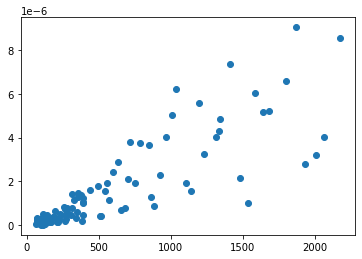

In [141]:
plt.scatter(x = dataset_UK["icu_patients"][ : 100], y = dataset_UK["Mortality_Rate"][7 : 107])

In [133]:
dataset_UK["icu_patients"][ : 7]

90078    2178.0
90079    2068.0
90080    2009.0
90081    1936.0
90082    1874.0
90083    1802.0
90084    1685.0
Name: icu_patients, dtype: float64

In [101]:
dataset_UK

,new_deaths,reproduction_rate,icu_patients,Mortality_Rate
date,,,,
2020-05-01,700.0,0.94,2178.0,1.031140e-05
2020-05-02,585.0,0.90,2068.0,8.617387e-06
2020-05-03,253.0,0.87,2009.0,3.726836e-06
2020-05-04,273.0,0.82,1936.0,4.021447e-06
2020-05-05,725.0,0.81,1874.0,1.067967e-05
...,...,...,...,...
2021-06-05,13.0,1.48,135.0,1.914975e-07
2021-06-06,4.0,1.48,145.0,5.892231e-08
2021-06-07,1.0,1.48,148.0,1.473058e-08


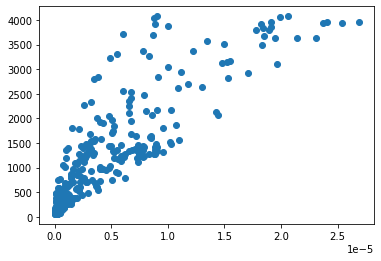

In [94]:
plt.scatter(x = dataset_UK["Mortality_Rate"], y = dataset_UK["reproduction_rate	"])

Text(0, 0.5, 'Y')

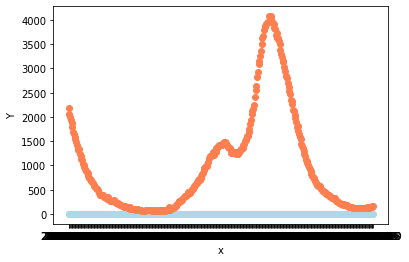

In [95]:
plt.scatter( x = dataset_UK.index, y = dataset_UK["Mortality_Rate"], c = "lightblue")
plt.scatter( x = dataset_UK.index, y = dataset_UK["icu_patients"], c = "coral")

plt.xlabel("x")
plt.ylabel("Y")

Text(0, 0.5, 'Y')

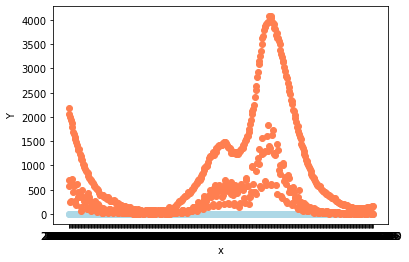

In [96]:
plt.scatter(x = dataset_UK.index, y = dataset_UK["Mortality_Rate"], c = "lightblue")
plt.scatter(x = dataset_UK.index, y = dataset_UK["icu_patients"], c = "coral")
plt.scatter(x = dataset_UK.index, y = dataset_UK["new_deaths"], c = "coral")

plt.xlabel("x")
plt.ylabel("Y")

In [ ]:
X_train

In [23]:
train = dataset_UK[ : 350]
test = dataset_UK[350 : ]

In [24]:
X_train = train.iloc[ : ,  : -1]
Y_train = train.iloc[ : , -1 : ]

X_test = test.iloc[ : ,  : -1]
Y_test = test.iloc[ : , -1 : ]

In [97]:
estimators = [
              ("rf", RandomForestRegressor(random_state = SEED)),
              ("svr", LinearSVR(random_state = SEED)),
              ("rf1", RandomForestRegressor(random_state = SEED)),
              ("xgb", xgb.XGBRegressor(random_state = SEED)),
              ("knn", KNeighborsRegressor(n_neighbors = 7))
]

reg = StackingRegressor(
    estimators = estimators, 
    final_estimator = RandomForestRegressor(random_state = SEED)
)

reg.fit(X_train, Y_train)
predict = reg.predict(X_test)

r2 = r2_score(Y_test, predict)


print(f"The r2 score is {r2}")


[13:15:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The r2 score is 0.3125902163884464


In [26]:
regressor = KNeighborsRegressor(n_neighbors = SEED)
regressor.fit(X_train, Y_train)

predict = regressor.predict(X_test)


r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")

------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------
The r2 score is : -1.7847472227485475
The Mean absolute error is : 1.8931023177494953e-07
The Mean squared error score is : 5.692927153211653e-14
------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------


In [27]:
estimators = [
              ("knn", KNeighborsRegressor(n_neighbors = 44)),
              ("xgb", xgb.XGBRegressor(random_state = SEED)),

]

reg = StackingRegressor(
    estimators = estimators ,
    final_estimator = KNeighborsRegressor(n_neighbors = 10)
)

reg.fit(X_train, Y_train)
predict = reg.predict(X_test)

r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")

[12:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------
The r2 score is : -4.244580412219203
The M

In [38]:
lasso = linear_model.Lasso(alpha = 5)
lasso.fit(X_train, Y_train)

predict = lasso.predict(X_train)

r2 = r2_score(Y_train, predict)
mae = mean_absolute_error(Y_train, predict)
mse = mean_squared_error(Y_train, predict)
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")

------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------
The r2 score is : 0.0
The Mean absolute error is : 0.7523482770227461
The Mean squared error score is : 1.0000000000000002
------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------


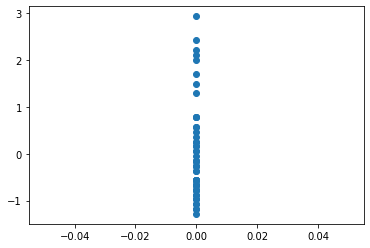

In [37]:
plt.scatter(predict, Y_test)

In [29]:
estimators = [
              ("knn", KNeighborsRegressor(n_neighbors = 44)),
              ("xgb", xgb.XGBRegressor(random_state = SEED)),
              ("lasso", linear_model.Lasso(alpha = 5))

]

reg = StackingRegressor(
    estimators = estimators ,
    final_estimator = KNeighborsRegressor(n_neighbors = 10)
)

reg.fit(X_train, Y_train)
predict = reg.predict(X_test)

r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")

[12:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------
The r2 score is : -3.3151997936798656
The 

In [30]:
estimators = [
              ("knn", KNeighborsRegressor(n_neighbors = 44)),
              #("xgb", xgb.XGBRegressor(random_state = SEED)),
              ("lasso", linear_model.Lasso(alpha = 5))

]

reg = StackingRegressor(
    estimators = estimators ,
    final_estimator = KNeighborsRegressor(n_neighbors = 10)
)

reg.fit(X_train, Y_train)
predict = reg.predict(X_test)

r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")

------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------
The r2 score is : -4.1431891548593995
The Mean absolute error is : 3.041194551008563e-07
The Mean squared error score is : 1.051434792882335e-13
------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------


In [31]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

Y_train = sc.fit_transform(Y_train)
Y_test = sc.fit_transform(Y_test) 

regressor = KNeighborsRegressor(n_neighbors = SEED)
regressor.fit(X_train, Y_train)

predict = regressor.predict(X_test)

r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")

------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------
The r2 score is : 0.2649956184757376
The Mean absolute error is : 0.6330872729493936
The Mean squared error score is : 0.7350043815242621
------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------


In [32]:
estimators = [
              ("knn", KNeighborsRegressor(n_neighbors = 44)),
              #("xgb", xgb.XGBRegressor(random_state = SEED)),
              ("lasso", linear_model.Lasso(alpha = 5))

]

reg = StackingRegressor(
    estimators = estimators ,
    final_estimator = KNeighborsRegressor(n_neighbors = 10)
)

reg.fit(X_train, Y_train)
predict = reg.predict(X_test)

r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")

------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------
The r2 score is : 0.2683285210842543
The Mean absolute error is : 0.6372232312193429
The Mean squared error score is : 0.7316714789157454
------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------


In [33]:
lasso = linear_model.Lasso(alpha = 5)
lasso.fit(X_train, Y_train)

predict = lasso.predict(X_test)

r2 = r2_score(Y_test, predict)
mae = mean_absolute_error(Y_test, predict)
mse = mean_squared_error(Y_test, predict)
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print(f"The r2 score is : {r2}")
print(f"The Mean absolute error is : {mae}")
print(f"The Mean squared error score is : {mse}")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")
print("------------------------------------------------")

------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------
The r2 score is : -2.220446049250313e-16
The Mean absolute error is : 0.7795200620804997
The Mean squared error score is : 0.9999999999999997
------------------------------------------------
------------------------------------------------
------------------------------------------------
------------------------------------------------
